# 前言

[ScanPy](https://scanpy.readthedocs.io/en/stable/) 是一个可扩展的工具包，用于分析single-cell gene expression data。它包含了用于preprocessing、visualization、clustering、pseudotime和trajectory inference、differential expression testing以及gene regulatory networks模拟的方法。使用使用基于Python的平台处理scRNA-seq数据具有诸多优势，包括提高处理效率和运行速度，以及与machine learning frameworks的无缝集成。

[ANNDATA](https://github.com/theislab/anndata) 与ScanPy一同推出，作为一个通用的class，用于处理annotated data matrices，能够有效应对gene expression data中固有的sparsity问题。

# 软件的安装   

请确保已安装Scanpy。Scanpy是一个python的软件包（packages）需要很多的python的依赖库，我们一般需要一个包/库管理软件（package manager）来进行安装环境的隔离和依赖库的正确安装调用，我们选取conda，colab中的conda项目名称为condacolab，我们先安装下这个。

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

检查下安装是否成功

In [ ]:
import condacolab
condacolab.check()

In [ ]:
!conda install -c conda-forge scanpy python-igraph leidenalg

In [ ]:
# import necessary packages
import numpy as np
import pandas as pd
import scanpy as sc

In [ ]:
sc.settings.verbosity = 3   # verbosity: errors (0), warnings (1), info (2), hints (3)

In [ ]:
# see what package versions you have installed
sc.logging.print_header()
# customize resolution and color of your figures
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [ ]:
# download the test data for this tutorial
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
!mkdir write

--2025-05-27 03:42:05--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2025-05-27 03:42:05--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7.27M  40.8MB/s    in 0.2s    

2025-05-27 03:42:06 (40.8 MB/s) - ‘data/pbmc3k_filtered_gene_bc_matri

In [ ]:
results_file = 'write/pbmc3k.h5ad' # the file that will store the analysis results

In [ ]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... writing an h5ad cache file to speedup reading next time


有关AnnData更全面的介绍，请参阅[anndata-tutorials/getting-started](https://anndata.readthedocs.io/en/latest/tutorials/notebooks/getting-started.html)。

In [ ]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [ ]:
# look at what the AnnData object contains
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

# 预处理

## 检查高度表达的基因（**highly expressed genes**）

显示在每个单细胞（single cell）中、跨所有细胞产生最高counts比例的genes。

`sc.pl.highest_expr_genes`命令对每个cell的counts进行均一化处理（normalizes），并绘制在每个cell中最丰富的genes。


normalizing counts per cell
    finished (0:00:00)


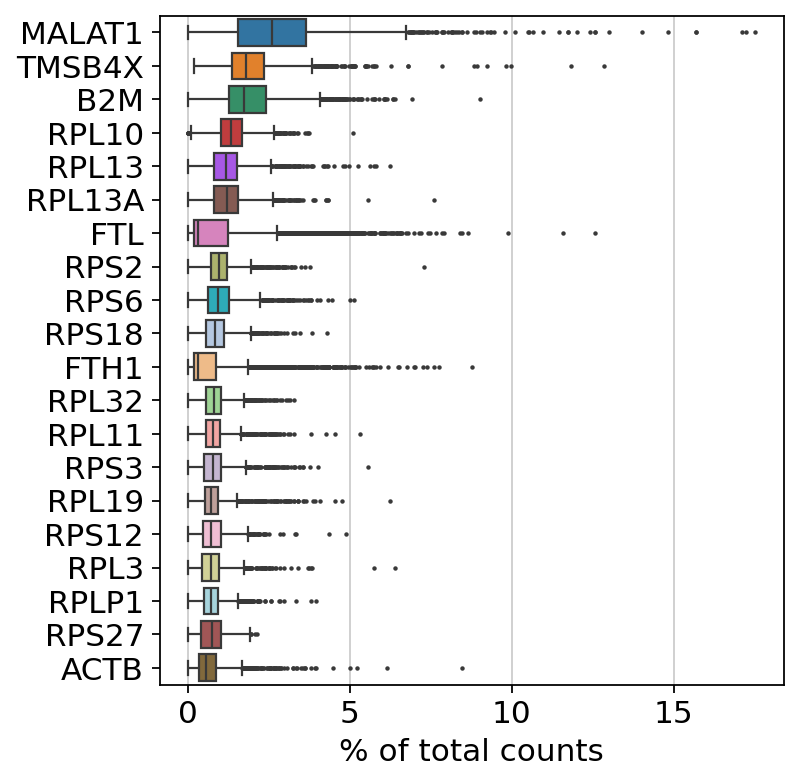

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=20, )

值得注意的是，MALAT1，一种已知在许多细胞中极其丰富的non-coding RNA，位居榜首。

## 基本过滤：移除具有low expression或missing values的cells和genes。

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


## 检查 线粒体基因 以进行 质量控制

让我们收集一些关于 线粒体基因 的信息，它们对于数据质量控制至关重要。

引用自“Simple Single Cell”workflows (Lun, McCarthy & Marioni, 2017)：

“高的比例或暗示细胞的质量较差 (Islam et al. 2014; Ilicic et al. 2016)，这可能是由于穿孔细胞（perforated cells） 中胞质内RNA（cytoplasmic RNA） 会大量丢失。其原因是 线粒体（mitochondria） 比单个转录子大，不太可能通过细胞膜的破裂处逸出。”

使用`pp.calculate_qc_metrics`，我们可以非常高效地计算许多相关的参数。

In [ ]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial gene as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

计算所得质量指标的小提琴图（violin plot）：

- 计数矩阵（count matrix）中表达的基因数量
- 每个细胞（cell）的总计数（total counts）
- 线粒体基因（mitochondrial genes）中的计数百分比

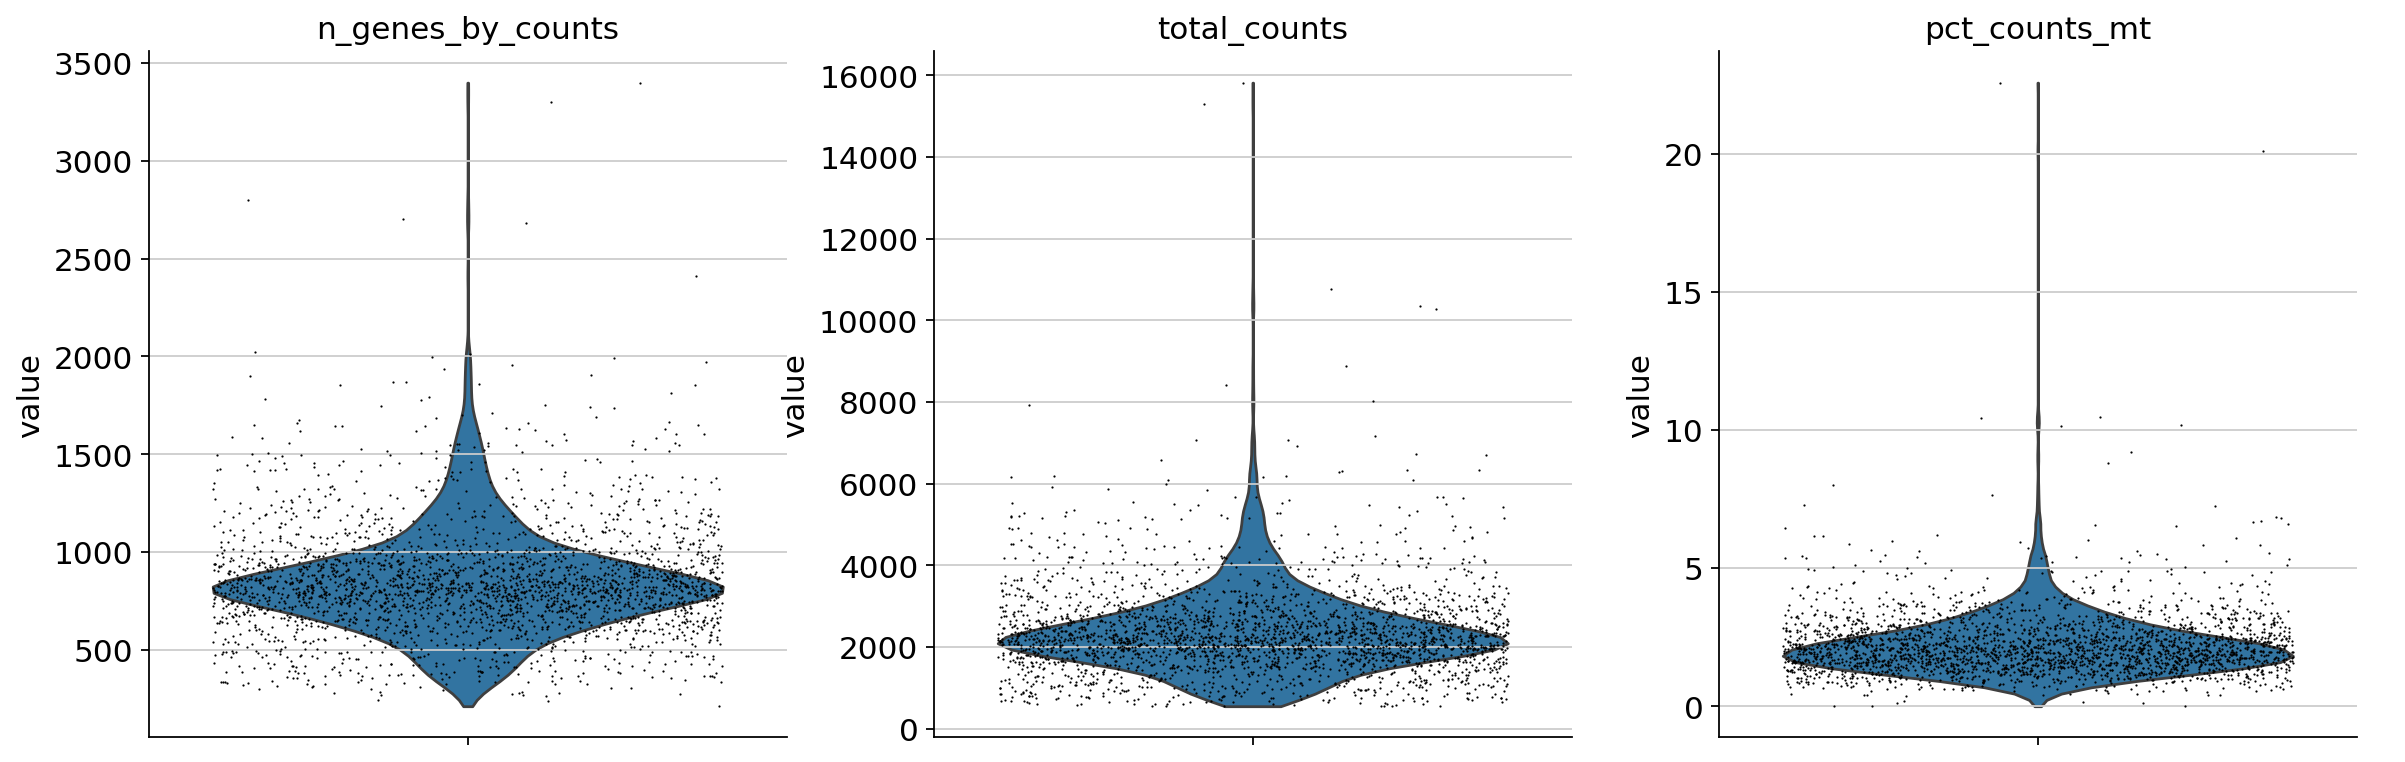

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

移除表达过多线粒体基因（mitochondrial genes）或总计数（total counts）过高的细胞（cells）。高比例的线粒体基因（mitochondrial genes）表达通常指示细胞质量不佳，这可能是由于细胞穿孔（perforated cells）导致细胞质RNA（cytoplasmic RNA）丢失所致。

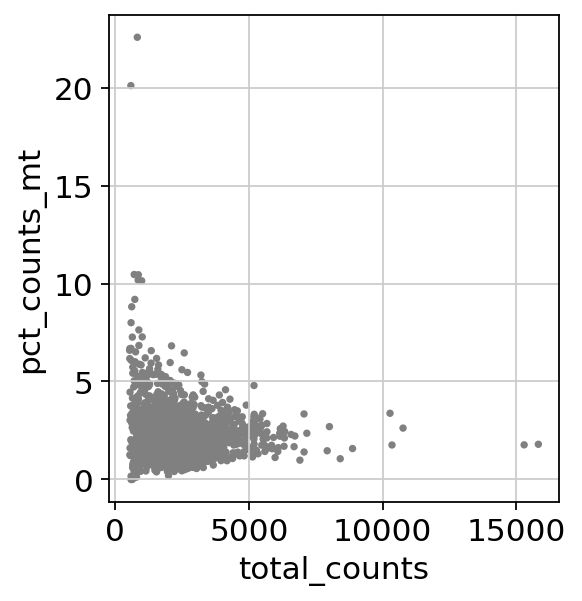

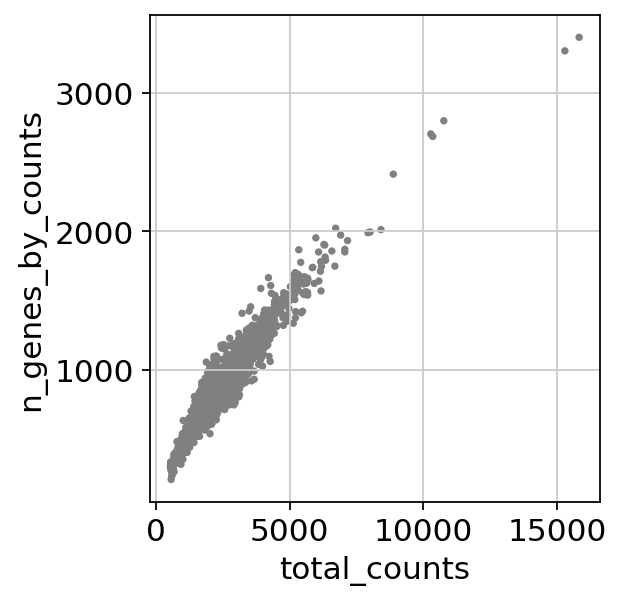

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

## 基于质量控制（QC）过滤数据

检查当前数据集（dataset），并通过分割（slicing）AnnData对象（object）对其进行过滤。

In [ ]:
print(adata)

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'


In [ ]:
# slice the adata object so you only keep genes and cells that pass the QC
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
print(adata)

View of AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'


## 数据归一化（Data normalization）

为了校正细胞间文库大小（library sizes）的差异，将数据矩阵（data matrix）的总读取计数（total read count）归一化（normalize）为每个细胞10,000次读取，以便细胞间的计数具有可比性。

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/usr/local/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


对数据进行对数转换（Log transform），以便后续用于差异基因表达（differential gene expression）分析和可视化（visualizations）。此处使用自然对数（natural logarithm），其中 `log1p` 表示在计数矩阵（count matrix）的细胞中添加一个额外的读取（read）作为伪读取（pseudo-read）。有关对数尺度（log scale）更适用于基因组数据（genomic data）的更多信息，请参阅[此处](https://www.biogazelle.com/seven-tips-bio-statistical-analysis-gene-expression-data)。

In [ ]:
sc.pp.log1p(adata)

## 识别高变基因（highly-variable genes）

函数 `sc.pp.highly_variable_genes` 可以根据一些手动设置的参数包括：
1. 最小平均表达量（minimum mean expression）
2. 最大平均表达量（maximum mean expression）
3. 最小离散度（minimum dispersion）

来检测标记基因（marker genes），这些基因有助于我们识别细胞。
我们将把分析重点放在这些基因上。


In [ ]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


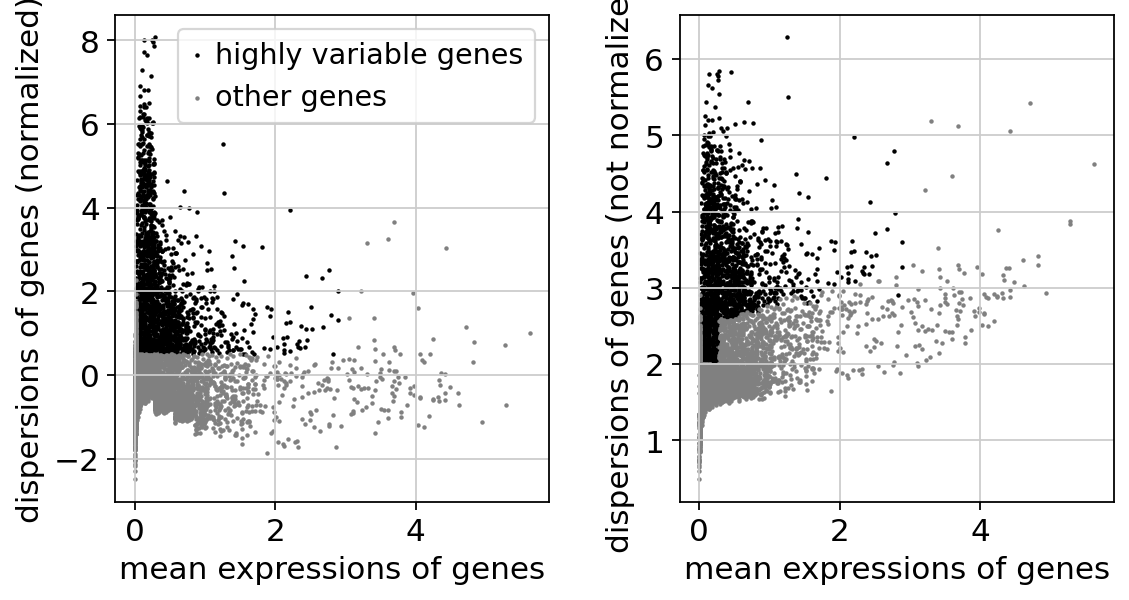

In [ ]:
# visualize the highly variable genes with a plot
sc.pl.highly_variable_genes(adata)

将AnnData对象（object）的`.raw`对象属性设置为归一化（normalized）和对数化（logarithmized）的原始基因表达（raw gene expression），以便后续用于差异检验（differential testing）和基因表达的可视化（visualizations）。这仅仅是冻结（freezes）了AnnData对象的状态。


In [ ]:
adata.raw = adata

过滤 `adata` 对象（object），仅保留高变基因（highly variable genes）。


In [ ]:
adata = adata[:, adata.var.highly_variable]

## 校正每个细胞的计数和线粒体基因表达的影响


回归（Regress out）每个细胞的总计数（total counts per cell）和线粒体基因（mitochondrial genes）表达百分比的影响。由于输入数据是稀疏的（sparse），这可能会消耗一些内存并花费一些时间。

In [ ]:
sc.pp.regress_out(adata, ['n_genes_by_counts', 'pct_counts_mt'])

regressing out ['n_genes_by_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/usr/local/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:710: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:648: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  data[i] -= regressor[i] @ coeff
/usr/local/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:648: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  data[i] -= regressor[i] @ coeff


    finished (0:00:04)


## 将数据中心化为零并缩放至单位方差（unit variance）

使用 `sc.pp.scale` 将每个基因的平均表达量（average expression）中心化为零。在此，我们还将超出标准差（standard deviation）10的缩放值（scaled values）进行裁剪（clipping）。

In [ ]:
sc.pp.scale(adata, max_value=10)

## 使用主成分分析（PCA）进行降维（Dimension reduction）

我们首先使用主成分分析（Principal Component Analysis, PCA）——一种线性降维（linear dimension-reduction）技术，以揭示变异（variation）的主要轴并对数据进行去噪（denoise）。

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:01)


我们可以在主成分分析（PCA）坐标中绘制散点图（scatter plot），但后续不会使用它。

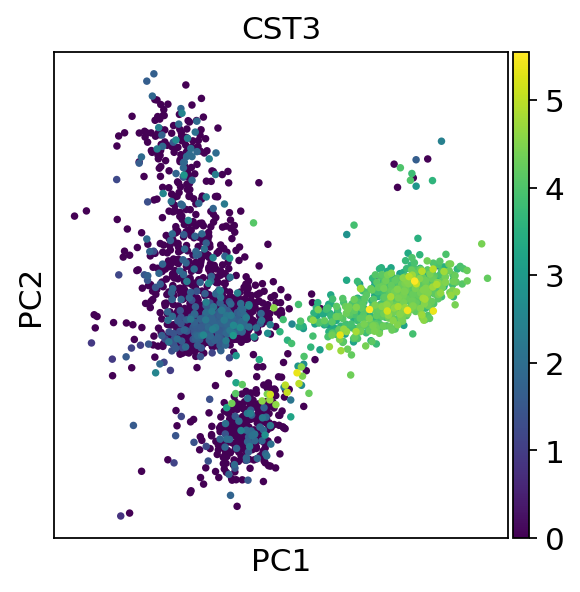

In [ ]:
sc.pl.pca(adata, color="CST3")

方差比图（variance ratio plot）列出了各个主成分（principal components, PC）对数据总方差（total variance）的贡献。这些信息有助于我们选择合适数量的主成分，以便计算细胞间的邻域关系（neighborhood relationships），例如，使用聚类方法Louvain `sc.tl.louvain()` 或降维（dimension-reduction）的嵌入方法tSNE `sc.tl.tsne()`。



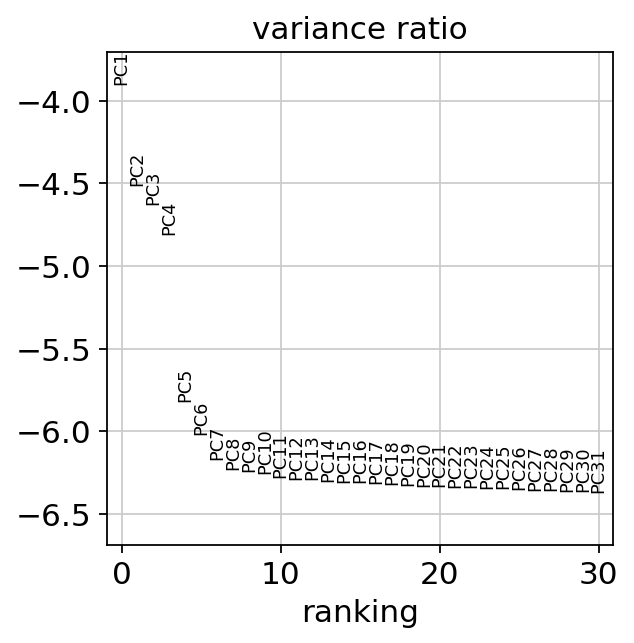

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

保存主成分分析（PCA）之前的结果。


In [ ]:
! mkdir -p write
adata.write(results_file)

请注意，我们的 `adata` 对象（object）包含以下元素：观测注释（observations annotation, obs）、变量（variables, var）、非结构化注释（unstructured annotation, uns）、多维观测注释（multi-dimensional observations annotation, obsm）和多维变量注释（multi-dimensional variables annotation, varm）。这些参数的含义在 `anndata` 包的文档中有所说明，可查阅[anndata 文档](https://anndata-tutorials.readthedocs.io/en/latest/getting-started.html)。


In [ ]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## 计算并嵌入邻域图（neighborhood graph）




使用数据矩阵（data matrix）的主成分分析（PCA）表示来计算细胞的邻域图（neighborhood graph）。1·

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:36)


Scanpy 的作者建议使用 UMAP（[McInnes et al., 2018](https://arxiv.org/abs/1802.03426)）将图（graph）嵌入（embedding）到二维空间中。UMAP 在保留流形（manifold）的全局连通性方面可能比 tSNE 更忠实，即它能更好地保留轨迹（trajectories）。


In [ ]:
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

由于我们设置了 `adata` 的 `.raw` 属性，之前的图表显示的是“原始”（raw）（已归一化（normalized）、已对数化（logarithmized），但未校正（uncorrected））的基因表达（gene expression）。您也可以通过明确声明不使用 `.raw` 来绘制缩放（scaled）和校正（corrected）后的基因表达。


In [ ]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

在某些情况下，您可能仍然会观察到断开的聚类（disconnected clusters）和类似的连接性违规（connectivity violations）。这些问题通常可以通过运行以下命令来解决：

In [ ]:
tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')

## 邻域图（neighborhood graph）聚类

与Seurat和许多其他框架一样，我们推荐[Traag _et al._ (2018)](https://arxiv.org/abs/1810.08473)提出的Leiden图聚类方法（基于优化模块度（modularity）的社区检测（community detection））。请注意，Leiden聚类直接对细胞的邻域图进行聚类，这在上一节中我们已经计算过。与Louvain算法相比，Leiden算法产生的社区（communities）保证是连通的（connected）。当迭代应用时，Leiden算法收敛到一个分区（partition），其中所有社区的所有子集都局部最优地分配。最后但同样重要的是，它的运行速度更快。


In [ ]:
sc.tl.leiden(adata)

使用 `sc.pl.umap` 绘制聚类（clusters）。请注意，`color` 参数（parameter）既接受单个基因（individual genes），也接受聚类方法（clustering method）（在本例中为leiden）。


In [ ]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

我们再次保存结果。

In [ ]:
adata.write(results_file)

## 识别标记基因（marker genes）


计算每个聚类（cluster）中高差异基因（highly differential genes）的排名。为此，默认情况下，如果AnnData的`.raw`属性已初始化，则使用该属性。最简单快捷的方法是t检验（t-test）。其他方法包括Wilcoxon秩和检验（Wilcoxon rank-sum test）（Mann-Whitney-U检验）、MAST、limma、DESeq2以及Theis实验室的diffxpy。Scanpy的作者建议在出版物中使用Wilcoxon秩和检验。

## Wilcoxon检验


为简化起见，我们从Mann-Whitney-U检验（Mann-Whitney-U test）开始。零假设（null hypothesis）是基因在某个聚类（cluster）中的排名与其在所有细胞（cells）中的排名相同。备择假设（alternative hypothesis）是基因在某个聚类中的排名远高于其在所有细胞中的排名（单侧（one-sided））。函数 `sc.tl.rank_genes_groups` 执行该检验，而 `sc.pl.rank_genes_groups` 绘制排名靠前的基因。

In [ ]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=15, sharey=False)

In [ ]:
sc.settings.verbosity = 2  # reduce the verbosity

In [ ]:
adata.write(results_file) # write the output to the results file

## 学生t检验（Student's t-test）

非参数Wilcoxon检验（non-parametric Wilcoxon test）的替代方法是t检验（t-test）。


In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=15, sharey=False)

作为替代方案，我们使用逻辑回归（logistic regression）对基因进行排序。例如，Natranos 等人（2018）曾提出此方法。本质区别在于，这里我们采用多变量（multi-variate）方法，而传统的差异检验是单变量（uni-variate）的。Clark 等人（2014）提供了更多细节。

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method="logreg")
sc.pl.rank_genes_groups(adata, n_genes=15, sharey=False)

我们还将定义一个标记基因（marker genes）列表，以供后续参考。

In [ ]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

## 使用Wilcoxon检验结果列出特征基因（signatures）

我们使用Wilcoxon检验（Wilcoxon's test）的结果进行下游分析（downstream analysis）。重新加载已保存的包含Wilcoxon秩和检验（Wilcoxon Rank-Sum test）结果的对象。

In [ ]:
adata = sc.read(results_file)

在数据框（dataframe）中显示每个聚类（cluster）0、1、…、7的前10个排名靠前的基因。

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

获取包含分数（scores）和组（groups）的表格。

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

与单个聚类（cluster）进行比较：

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

如果我们需要查看某个特定组的更详细视图，请使用 `sc.pl.rank_genes_groups_violin`。

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

如果您想比较不同组（groups）之间的某个基因（gene），请使用以下方法。

In [ ]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

实际标记细胞类型（cell types）。


In [ ]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)


In [ ]:
# plot the UMAP
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

既然我们已经注释了细胞类型（cell types），现在让我们可视化标记基因（marker genes）。

In [ ]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

还有一个非常紧凑的小提琴图（violin plot）。

In [ ]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);

在本次分析过程中，AnnData累积了以下注释（annotations）。

In [ ]:
adata

如果您想保存结果：


In [ ]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

使用 `h5ls` 获取文件的粗略概览，`h5ls` 有许多选项——更多详情请参阅[此处](https://www.hdfgroup.org/HDF5/doc/RM/Tools.html#Tools-h5ls)。文件格式未来可能仍会进一步优化。不过，所有读取函数都将保持向后兼容（backwards-compatible）。

如果您想与仅希望将其用于可视化（visualization）的人共享此文件，一种简单的减小文件大小的方法是移除密集的缩放（scaled）和校正（corrected）数据矩阵（data matrix）。文件仍包含 `adata.raw` 中用于可视化的原始数据（raw data）。


In [ ]:
adata.raw.to_adata().write('./write/pbmc3k_withoutX.h5ad')

如果您想导出为“csv”格式，您有以下选项：

In [ ]:
Export single fields of the annotation of observations
adata.obs[['n_counts', 'louvain_groups']].to_csv(
    './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )